<a href="https://colab.research.google.com/github/Mochismo/LearnPython/blob/main/30_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem 1

From the scratch implementations:


*   We had to initialize weights
*   We needed an epoch loop
*   We coded the activation functions
*   We decided the learning rate, sizes, number of nodes and so on.



Problem 2

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf = tf.compat.v1
tf.disable_v2_behavior()

#Getting the Iris dataset and preparing the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)
X 

# Convert labels to numbers
y[y=='Iris-versicolor'] = 0
y[y=='Iris-virginica'] = 1
y = y.astype(np.int)[:, np.newaxis]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Further split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:

    # Iterator to get the mini-batch
    
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# Configure hyperparameters
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# Determine the form of the arguments to be passed to the computational graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train's mini-batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    
    """
    A simple three-layer neural network
    """
    # Declaring weights and biases

    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    
    # tf.add and + are equivalent
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output

# Load the network structure 
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))

# Optimization methods
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimation results
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))

# Index value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variable
init = tf.global_variables_initializer()

# Run a computational graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # Loop per epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 52.0394, val_loss : 33.5849, acc : 0.250, val_acc : 0.625
Epoch 1, loss : 10.1124, val_loss : 25.9346, acc : 0.750, val_acc : 0.375
Epoch 2, loss : 11.2048, val_loss : 14.1081, acc : 0.750, val_acc : 0.625
Epoch 3, loss : 1.2206, val_loss : 8.7826, acc : 0.750, val_acc : 0.438
Epoch 4, loss : 4.8134, val_loss : 7.8843, acc : 0.750, val_acc : 0.688
Epoch 5, loss : 0.0000, val_loss : 1.7232, acc : 1.000, val_acc : 0.750
Epoch 6, loss : 0.0002, val_loss : 2.1494, acc : 1.000, val_acc : 0.875
Epoch 7, loss : 0.0002, val_loss : 2.3657, acc : 1.000, val_acc : 0.875
Epoch 8, loss : 0.0000, val_loss : 1.1446, acc : 1.000, val_acc : 0.875
Epoch 9, loss : 1.0139, val_loss : 5.8009, acc : 0.750, val_acc : 0.688
test_acc : 0.800


Problem3

All three types of objective variables

In [13]:
#Getting the Iris dataset and preparing the variables and target
dataset_path ="/content/drive/MyDrive/Iris.csv"
df = pd.read_csv(dataset_path)

y = df["Species"]
X = df.loc[:, ["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]]
y = np.array(y)
X = np.array(X)

# Convert labels to numbers
y[y=='Iris-setosa'] = 0
y[y=='Iris-versicolor'] = 1
y[y=='Iris-virginica'] = 2
y = y.astype(np.int)[:, np.newaxis]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Further split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# One-hot encoding of correct label value
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

class GetMiniBatch:

    # Iterator to get the mini-batch
    
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# Configure hyperparameters
learning_rate = 0.01
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3

# Determine the form of the arguments to be passed to the computational graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train's mini-batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    
    """
    A simple three-layer neural network
    """
    # Declaring weights and biases
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output
 
# Load the network structure 
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# Optimization methods
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimation results
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))

# Index value calculation
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variable
init = tf.global_variables_initializer()

# Run a computational graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # Loop per epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 0.6590, val_loss : 15.6386, acc : 0.667, val_acc : 0.625
Epoch 1, loss : 0.1329, val_loss : 3.7865, acc : 0.833, val_acc : 0.667
Epoch 2, loss : 0.0000, val_loss : 2.1666, acc : 1.000, val_acc : 0.917
Epoch 3, loss : 0.0077, val_loss : 4.1009, acc : 1.000, val_acc : 0.792
Epoch 4, loss : 0.0003, val_loss : 4.1552, acc : 1.000, val_acc : 0.875
Epoch 5, loss : 0.0000, val_loss : 2.5708, acc : 1.000, val_acc : 0.917
Epoch 6, loss : 0.0000, val_loss : 1.4122, acc : 1.000, val_acc : 0.833
Epoch 7, loss : 0.0000, val_loss : 4.1130, acc : 1.000, val_acc : 0.750
Epoch 8, loss : 0.0000, val_loss : 10.1753, acc : 1.000, val_acc : 0.625
Epoch 9, loss : 0.0000, val_loss : 6.6393, acc : 1.000, val_acc : 0.667
test_acc : 0.933


Problem 4

Model using the House Prices

Epoch 0, loss : 622837.6250, val_loss : 531596.0000
Epoch 1, loss : 87521.8516, val_loss : 88678.2422
Epoch 2, loss : 55369.6836, val_loss : 54628.9375
Epoch 3, loss : 59290.9609, val_loss : 46546.9453
Epoch 4, loss : 34019.7656, val_loss : 37747.8789
Epoch 5, loss : 26076.6621, val_loss : 27917.8848
Epoch 6, loss : 22524.7344, val_loss : 23553.4609
Epoch 7, loss : 19543.1406, val_loss : 20404.0586
Epoch 8, loss : 16282.1084, val_loss : 17471.7910
Epoch 9, loss : 10986.9922, val_loss : 12676.5498
test_mse : 10986.992


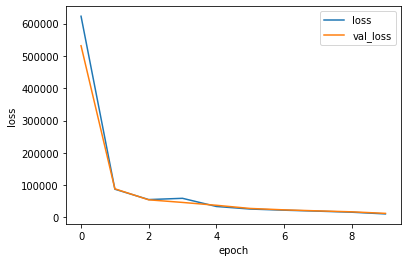

In [14]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

#Getting the Iris dataset and preparing the variables and target
dataset_path ="/content/drive/MyDrive/train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Further split into train and val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

class GetMiniBatch:

    # Iterator to get the mini-batch
    
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# Configure hyperparameters
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# Determine the form of the arguments to be passed to the computational graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train's mini-batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    
    """
    A simple three-layer neural network
    """
    # Declaring weights and biases    
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output

# Load the network structure 
logits = example_net(X)

# Objective function
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)

# Optimization methods
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Estimation results
train_op = optimizer.minimize(loss_op)

y_pred = logits

# Initialize the variable
init = tf.global_variables_initializer()

# Run a computational graph
with tf.Session() as sess:
    sess.run(init)
    loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        # Loop per epoch
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        loss_list.append(loss)
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    print("test_mse : {:.3f}".format(loss))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()

Problem 5

Model that classifies the MNIST

In [15]:
# Download the MNIST dataset
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Flatten
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Type conversion, normalization
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

#Split into train and validations sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

class GetMiniBatch:
    
    # Iterator to get the mini-batch

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

# Configure hyperparameters
learning_rate = 0.01
batch_size = 10
num_epochs = 10

n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10

# Determine the form of the arguments to be passed to the computational graph
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# train's mini-batch iterator
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    
    """
    A simple three-layer neural network
    """
    # Declaring weights and biases  
    
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }

    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3'] 
    return layer_output

# Load the network structure                                
logits = example_net(X)

# Objective function
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits))

# Optimization methods
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Estimation results
max_Y = (tf.argmax(Y, 1))
max_Y_pred = tf.argmax(logits, 1)
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

#initialize the variable
init = tf.global_variables_initializer()

# Run a computational graph
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
        # Loop per epoch
        total_batch = np.ceil(X_train.shape[0]/batch_size).astype(np.int)
        total_loss = 0
        total_acc = 0
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # Loop for each mini-batch
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: mini_batch_x, Y: mini_batch_y})
            total_loss += loss
            total_acc += acc
        total_loss /= n_samples
        total_acc /= n_samples
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}, acc : {:.3f}, val_acc : {:.3f}".format(epoch, loss, val_loss, acc, val_acc))
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    print("test_acc : {:.3f}".format(test_acc))

Epoch 0, loss : 1.7563, val_loss : 1.3115, acc : 0.700, val_acc : 0.611
Epoch 1, loss : 1.7962, val_loss : 1.1792, acc : 0.700, val_acc : 0.605
Epoch 2, loss : 1.1392, val_loss : 0.7899, acc : 0.700, val_acc : 0.710
Epoch 3, loss : 0.7814, val_loss : 0.4994, acc : 0.700, val_acc : 0.869
Epoch 4, loss : 0.8545, val_loss : 0.4140, acc : 0.700, val_acc : 0.888
Epoch 5, loss : 0.3320, val_loss : 0.4330, acc : 0.900, val_acc : 0.893
Epoch 6, loss : 0.9279, val_loss : 0.3793, acc : 0.800, val_acc : 0.897
Epoch 7, loss : 0.2194, val_loss : 0.3325, acc : 0.800, val_acc : 0.915
Epoch 8, loss : 0.5005, val_loss : 0.3536, acc : 0.800, val_acc : 0.919
Epoch 9, loss : 0.9110, val_loss : 0.3664, acc : 0.800, val_acc : 0.913
test_acc : 0.914
